# Feature selection with the debiased Gini importance

This notebook explores the performance of the new debiased Gini importance and its feature selection behavior

In [1]:
import rpy2.robjects as robjects
import numpy as np
from irf.ensemble import wrf
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from irf import irf_utils, irf_jupyter_utils
from treeinterpreter.feature_importance import feature_importance
from sklearn.preprocessing import OneHotEncoder

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## read the data

In [2]:
tmp = robjects.r['load']('../iRF_analyses/data/enhancer.Rdata')
print(tmp)
X = robjects.r["X"]
XX = np.asarray(X)
print(XX)
assert(len(XX[0]) == X.ncol) #same number of cols
assert(len(XX) == X.nrow)
X = XX
Y = robjects.r["Y"]
Y = np.asarray(Y)
assert(len(Y) == len(X))
test = np.asarray(robjects.r["test.id"])
train = np.asarray(robjects.r["train.id"])
varnames = np.asarray(robjects.r["varnames.all"])

[1] "X"            "Y"            "test.id"      "train.id"     "varnames.all"

[[ 6.      10.      10.      ...  0.       0.       0.     ]
 [ 6.       7.       6.      ...  0.       0.       0.     ]
 [14.       9.      14.      ...  0.       0.       1.2013 ]
 ...
 [ 9.      12.      16.      ...  2.13176  2.22051  1.20134]
 [17.      18.      14.      ...  1.49709  1.39971  1.26398]
 [13.      15.      18.      ...  2.03769  2.03994  0.     ]]


## train test split

In [3]:
X_train = X[train-1,:]
X_test = X[test-1,:]
y_train = Y[train - 1]
y_test = Y[test - 1]

In [4]:
X_train.shape

(3912, 80)

## train RF

In [5]:
rf = RandomForestClassifier(n_estimators=3000, max_depth=5)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=3000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## calculate debiased Gini importance

In [6]:
#test_importance, test_SE = test_feature_importance(rf, X_test, y_test)
y_test_one_hot = OneHotEncoder().fit(y_train[:,np.newaxis]).transform(y_test[:,np.newaxis]).todense()
test_importance, test_SE = feature_importance(rf, X_test, y_test_one_hot, type='classic')

## plot the feature importance

<BarContainer object of 80 artists>

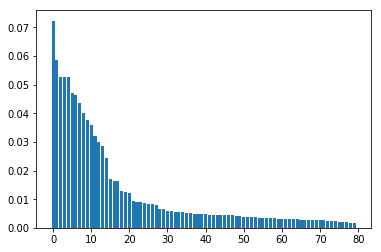

In [7]:
p = len(rf.feature_importances_)
plt.bar(x = list(reversed(range(p))), height = np.sort(rf.feature_importances_))

## plot debiased feature importance

<BarContainer object of 80 artists>

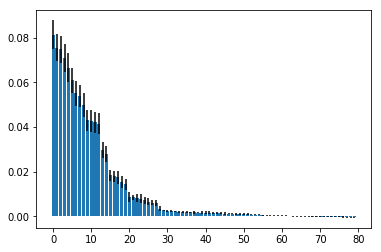

In [8]:
#stat_sig = 
ix = np.argsort(test_importance)
plt.bar(x = list(reversed(range(p))), height = test_importance[ix], yerr = test_SE[ix] * 2)

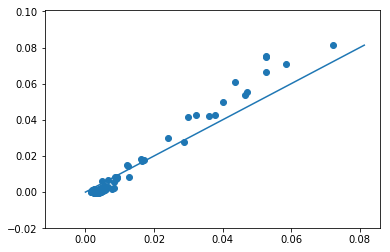

In [9]:
### plot their difference
plt.scatter(x = rf.feature_importances_, y= test_importance, marker='o')
plt.plot([0, max(test_importance)], [0, max(test_importance)])

## give the set of features that is above the threshold

In [10]:
varnames[1,:].shape

(80,)

In [17]:
ix = np.argsort(test_importance)
selected_features = test_importance[ix] > test_SE[ix] * 3
varnames[1,selected_features] # from least important to most important

array(['H3K4me3', 'H3K4me3', 'H3K9ac', 'H3K9ac', 'H3K9ac', 'H3K9ac',
       'H4K5ac', 'H4K5ac', 'H4K5ac', 'H4K5ac', 'H4K8ac', 'H4K8ac',
       'H4K8ac', 'H4K8ac', 'input1', 'input2', 'input3', 'input4',
       'wt_H3', 'wt_H3K18ac', 'wt_H3K4me1', 'wt_ZLD', 'bcd', 'bcd',
       'cad1', 'D1', 'da2', 'dl3', 'ftz3', 'gt2', 'h', 'h', 'hb', 'hb',
       'hkb', 'hkb', 'hkb', 'kni', 'kni', 'kr', 'kr', 'mad2', 'med2',
       'prdBQ', 'prdFQ', 'run', 'run', 'shn', 'shn', 'slp', 'sna', 'sna',
       'tll', 'twi', 'twi', 'z2'], dtype='<U13')

# do the same analysis but with permuted labels

## permute the labels

In [18]:
Y = np.random.permutation(Y)

## train test split

In [19]:
X_train = X[train-1,:]
X_test = X[test-1,:]
y_train = Y[train - 1]
y_test = Y[test - 1]

## train RF

In [20]:
rf = RandomForestClassifier(n_estimators=3000, max_depth=5)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=3000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## calculate debiased Gini importance

In [24]:
y_test_one_hot = OneHotEncoder().fit(y_train[:,np.newaxis]).transform(y_test[:,np.newaxis]).todense()
test_importance, test_SE = feature_importance(rf, X_test, y_test_one_hot, type = 'test')

## plot the feature importance

<BarContainer object of 80 artists>

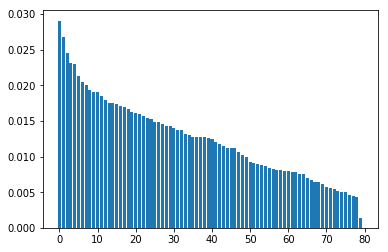

In [25]:
p = len(rf.feature_importances_)
plt.bar(x = list(reversed(range(p))), height = np.sort(rf.feature_importances_))

## plot debiased feature importance

<BarContainer object of 80 artists>

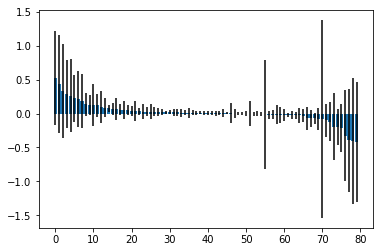

In [26]:
#stat_sig = 
ix = np.argsort(test_importance)
plt.bar(x = list(reversed(range(p))), height = test_importance[ix], yerr = test_SE[ix] * 2)

## debiased Gini importance is close to zero